# DFT 交换关联泛函

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/05-dft-xc.ipynb)

## 学习目标

- 理解局域密度近似（LDA）的物理基础
- 掌握 Dirac 交换和 PZ81/VWN 关联泛函
- 对比不同 XC 泛函对计算结果的影响

## LDA 的物理图像

局域密度近似假设交换关联能量密度仅依赖局域电子密度：

$$E_{\mathrm{xc}}[n] = \int \epsilon_{\mathrm{xc}}(n(r)) n(r) dr$$

其中 $\epsilon_{\mathrm{xc}}(n)$ 由均匀电子气模型确定。

### Dirac 交换

$$\epsilon_x(n_\sigma) = -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} n_\sigma^{1/3}$$

$$v_x^\sigma = \frac{\delta E_x}{\delta n_\sigma} = -\left(\frac{3}{\pi}\right)^{1/3} n_\sigma^{1/3}$$

## 理论基础：LDA 交换关联泛函

密度泛函理论（DFT）将多体问题简化为单粒子 Kohn-Sham 方程。

### 局域密度近似（LDA）

交换关联能密度：

$$\varepsilon_{xc}[n(r)] \approx \varepsilon_{xc}^{\text{hom}}(n(r))$$

使用均匀电子气结果：

#### Dirac 交换

$$\varepsilon_x(n) = -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

$$v_x(n) = \frac{\delta E_x}{\delta n} = -\left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

#### PZ81 关联

Perdew-Zunger 1981 参数化 Ceperley-Alder QMC 结果：

$$\varepsilon_c(r_s, \zeta) = \begin{cases}
A\ln r_s + B + Cr_s\ln r_s + Dr_s & r_s \geq 1 \\
\gamma/(1+\beta_1\sqrt{r_s}+\beta_2 r_s) & r_s < 1
\end{cases}$$

其中 $r_s = (3/(4\pi n))^{1/3}$ 为 Wigner-Seitz 半径。

**代码实现**：
- `vx_dirac(n)` → 交换势
- `lda_c_pz81(n_up, n_dn)` → 关联势与能量


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81, run_lsda_vwn
from atomscf.xc.lda import vx_dirac, ex_dirac_density, lda_c_pz81
from atomscf.xc.vwn import lda_c_vwn

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)


def safe_energy(result, key):
    return result.energies.get(key, 0.0) if result.energies else 0.0


def get_eps(result, l, spin='up', idx=0):
    eps_list = result.eps_by_l_sigma.get((l, spin), [])
    return eps_list[idx] if idx < len(eps_list) else 0.0



## XC 势与能量密度

可视化交换和关联势对密度的依赖：

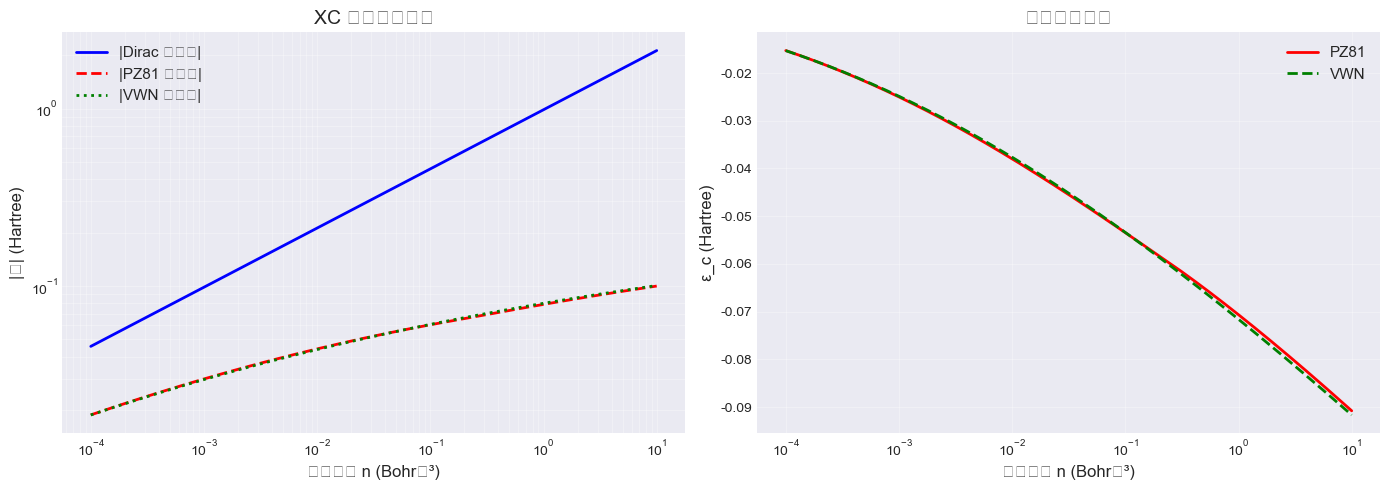

In [4]:
# 测试密度范围
n_test = np.logspace(-4, 1, 200)  # 10⁻⁴ 到 10 Bohr⁻³

# 计算 Dirac 交换势
vx_test = vx_dirac(n_test)

# 计算 PZ81 关联
eps_c_pz81, vc_up_pz81, vc_dn_pz81, ec_pz81 = lda_c_pz81(n_test / 2, n_test / 2)

# 计算 VWN 关联
eps_c_vwn, vc_up_vwn, vc_dn_vwn, ec_vwn = lda_c_vwn(n_test / 2, n_test / 2)

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：交换关联势
ax1.loglog(n_test, -vx_test, 'b-', linewidth=2, label='|Dirac 交换势|')
ax1.loglog(n_test, -vc_up_pz81, 'r--', linewidth=2, label='|PZ81 关联势|')
ax1.loglog(n_test, -vc_up_vwn, 'g:', linewidth=2, label='|VWN 关联势|')
ax1.set_xlabel('电子密度 n (Bohr⁻³)', fontsize=12)
ax1.set_ylabel('|势| (Hartree)', fontsize=12)
ax1.set_title('XC 势随密度变化', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, which='both')

# 右图：关联能量密度
ax2.semilogx(n_test, eps_c_pz81, 'r-', linewidth=2, label='PZ81')
ax2.semilogx(n_test, eps_c_vwn, 'g--', linewidth=2, label='VWN')
ax2.set_xlabel('电子密度 n (Bohr⁻³)', fontsize=12)
ax2.set_ylabel('ε_c (Hartree)', fontsize=12)
ax2.set_title('关联能量密度', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("关键观察:")
print("  • 交换势 ∝ n^(1/3)，关联势在低密度区增强")
print("  • PZ81 和 VWN 在中等密度区非常接近")
print("  • 高密度极限：交换占主导")

## Al 原子：PZ81 vs VWN

对比两种关联泛函的计算结果：

In [5]:

# 生成网格
r, w = radial_grid_linear(n=800, rmin=1e-5, rmax=30.0)

# Al 原子配置（Z=13 会自动使用 default_occupations）

# PZ81 计算
cfg_pz81 = SCFConfig(Z=13, r=r, w=w, maxiter=50, tol=1e-6)
result_pz81 = run_lsda_pz81(cfg_pz81)

# VWN 计算
cfg_vwn = SCFConfig(Z=13, r=r, w=w, maxiter=50, tol=1e-6)
result_vwn = run_lsda_vwn(cfg_vwn)

print('Al 原子泛函比较:')
print('  泛函      总能量 (Ha)   E_xc (Ha)   3s 能量 (eV)')
print('  ' + '-' * 58)

E_total_pz81 = safe_energy(result_pz81, 'E_total')
E_xc_pz81 = safe_energy(result_pz81, 'E_xc')
eps_3s_pz81 = get_eps(result_pz81, l=0, spin='up', idx=2)

E_total_vwn = safe_energy(result_vwn, 'E_total')
E_xc_vwn = safe_energy(result_vwn, 'E_xc')
eps_3s_vwn = get_eps(result_vwn, l=0, spin='up', idx=2)

print(f"  PZ81     {E_total_pz81:>12.6f}  {E_xc_pz81:>10.6f}  {eps_3s_pz81*27.211:>12.3f}")
print(f"  VWN      {E_total_vwn:>12.6f}  {E_xc_vwn:>10.6f}  {eps_3s_vwn*27.211:>12.3f}")
print(f"\n  能量差: {abs(E_total_pz81 - E_total_vwn):.6f} Ha")
print(f"  能量差: {abs(E_total_pz81 - E_total_vwn) * 27.211:.3f} eV")



## XC 势空间分布

可视化 Al 原子的交换关联势：

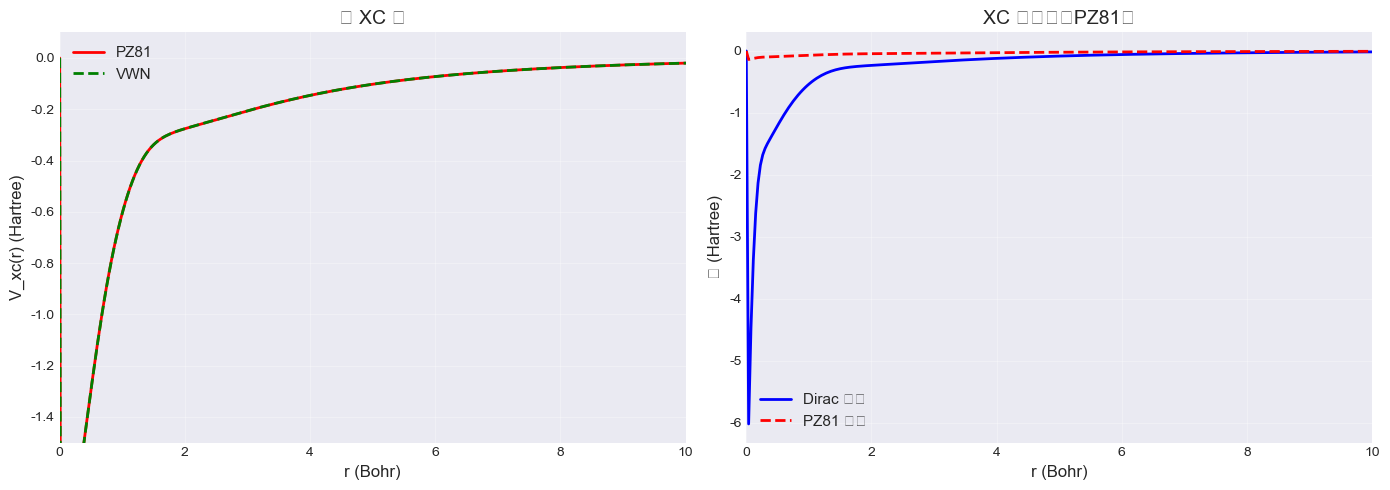

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：总 XC 势
v_xc_pz81 = result_pz81.v_x_up + (result_pz81.v_c_up if result_pz81.v_c_up is not None else 0.0)  # 自旋向上分量
v_xc_vwn = result_vwn.v_x_up + (result_vwn.v_c_up if result_vwn.v_c_up is not None else 0.0)

ax1.plot(r, v_xc_pz81, 'r-', linewidth=2, label='PZ81')
ax1.plot(r, v_xc_vwn, 'g--', linewidth=2, label='VWN')
ax1.set_xlabel('r (Bohr)', fontsize=12)
ax1.set_ylabel('V_xc(r) (Hartree)', fontsize=12)
ax1.set_title('总 XC 势', fontsize=14)
ax1.set_xlim(0, 10)
ax1.set_ylim(-1.5, 0.1)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 右图：交换与关联分量
ax2.plot(r, result_pz81.v_x_up, 'b-', linewidth=2, label='Dirac 交换')
ax2.plot(r, result_pz81.v_c_up, 'r--', linewidth=2, label='PZ81 关联')
ax2.set_xlabel('r (Bohr)', fontsize=12)
ax2.set_ylabel('势 (Hartree)', fontsize=12)
ax2.set_title('XC 势分量（PZ81）', fontsize=14)
ax2.set_xlim(0, 10)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nXC 势特征:")
print(f"  核附近（r=0.1）: V_xc = {v_xc_pz81[np.argmin(np.abs(r-0.1))]:.4f} Ha")
print(f"  远区（r=5.0）:   V_xc = {v_xc_pz81[np.argmin(np.abs(r-5.0))]:.4f} Ha")

## LDA 泛函对比总结

| 泛函 | 适用场景 | 优点 | 缺点 |
|------|---------|------|------|
| PZ81 | 标准基准 | 参数简单、收敛稳定 | 高密度区略欠精确 |
| VWN | 高精度计算 | 低密度区更准确 | 参数复杂 |

**实际应用建议**：
- 教学演示：优先 PZ81（参数少、公式简洁）
- 高精度计算：使用 VWN（低密度区更准确）
- 对大多数原子，两者差异 < 0.1 eV

## 关键概念

- **局域近似**：$\epsilon_{\mathrm{xc}}(n(r))$ 仅依赖 $n(r)$，忽略梯度
- **势的导出**：$v_{\mathrm{xc}} = \delta E_{\mathrm{xc}} / \delta n$
- **自旋极化**：$\epsilon_c(n, \zeta)$ 依赖自旋极化度 $\zeta = (n_\uparrow - n_\downarrow) / n$

## 下一步

在 **[06-spin.ipynb](06-spin.ipynb)** 中，学习如何处理开壳层体系的自旋问题。